In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

# Utility: BN → ReLU → Conv
def bn_rl_conv(x, filters, kernel_size):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    return x

# Dense block: repeating BN-ReLU-Conv1x1 + BN-ReLU-Conv3x3
def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = bn_rl_conv(tensor, filters=4 * k, kernel_size=1)
        x = bn_rl_conv(x, filters=k, kernel_size=3)
        tensor = Concatenate()([tensor, x])
    return tensor

# Transition layer: compression + pooling
def transition_layer(x, theta):
    f = int(tf.keras.backend.int_shape(x)[-1] * theta)
    x = bn_rl_conv(x, filters=f, kernel_size=1)
    x = AvgPool2D(pool_size=2, strides=2, padding='same')(x)
    return x

# Model Parameters
k = 32                  # Growth rate
theta = 0.5             # Compression factor
repetitions = (6, 12, 24, 16)  # Dense block repetitions

# Model input
input = Input(shape=(224, 224, 3))

# Initial conv + pool
x = Conv2D(2 * k, 7, strides=2, padding='same')(input)
x = MaxPool2D(3, strides=2, padding='same')(x)

# Dense blocks with transitions
for reps in repetitions[:-1]:
    x = dense_block(x, k, reps)
    x = transition_layer(x, theta)

# Final dense block (no transition after)
x = dense_block(x, k, repetitions[-1])

# Classification head
x = GlobalAvgPool2D()(x)
output = Dense(6, activation='softmax')(x)  # Categorical output

# Build and compile model
from tensorflow.keras import Model
model = Model(input, output)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Categorical mode for 6-class classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dense-categorical/dental-categorical/training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # ✅ changed from 'binary'
    shuffle=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/dense-categorical/dental-categorical/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # ✅ changed from 'binary'
    shuffle=False
)


Found 3024 images belonging to 6 classes.
Found 2976 images belonging to 6 classes.


In [18]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',  # or use FocalLoss if you tried that
    metrics=['accuracy']
)


In [19]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
    ]
)

Epoch 1/15


I0000 00:00:1750404328.387178      97 service.cc:148] XLA service 0x7b4e38005ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750404328.389693      97 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750404328.389717      97 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750404338.882586      97 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750404428.974761      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


95/95 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 0.5841 - loss: 0.9510 - val_accuracy: 0.1667 - val_loss: 2.5745 - learning_rate: 1.0000e-04
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 89s 941ms/step - accuracy: 0.7489 - loss: 0.5602 - val_accuracy: 0.1670 - val_loss: 2.4960 - learning_rate: 1.0000e-04
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 90s 950ms/step - accuracy: 0.7577 - loss: 0.5401 - val_accuracy: 0.2060 - val_loss: 2.8235 - learning_rate: 1.0000e-04
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 90s 950ms/step - accuracy: 0.7708 - loss: 0.5052 - val_accuracy: 0.4224 - val_loss: 1.6764 - learning_rate: 1.0000e-04
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 91s 956ms/step - accuracy: 0.7929 - loss: 0.4739 - val_accuracy: 0.6274 - val_loss: 0.8707 - learning_rate: 1.0000e-04
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 92s 969ms/step - accuracy: 0.7988 - loss: 0.4608 - val_accuracy: 0.7860 - val_loss: 0.4554 - learning_rate: 1.0000e-04
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 92s 966ms/step - accuracy: 0.8068

In [20]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 336ms/step - accuracy: 0.9001 - loss: 0.2276
Test Loss: 0.3214, Test Accuracy: 0.8579


93/93 ━━━━━━━━━━━━━━━━━━━━ 33s 358ms/step
Classification Report:

                        precision    recall  f1-score   support

dyed-resection-margins       1.00      0.99      0.99       496
           esophagitis       0.72      0.79      0.75       496
        normal-pylorus       0.96      0.97      0.97       496
         normal-z-line       0.77      0.69      0.72       496
                 polyp       0.90      0.79      0.84       496
    ulcerative-colitis       0.82      0.93      0.87       496

              accuracy                           0.86      2976
             macro avg       0.86      0.86      0.86      2976
          weighted avg       0.86      0.86      0.86      2976



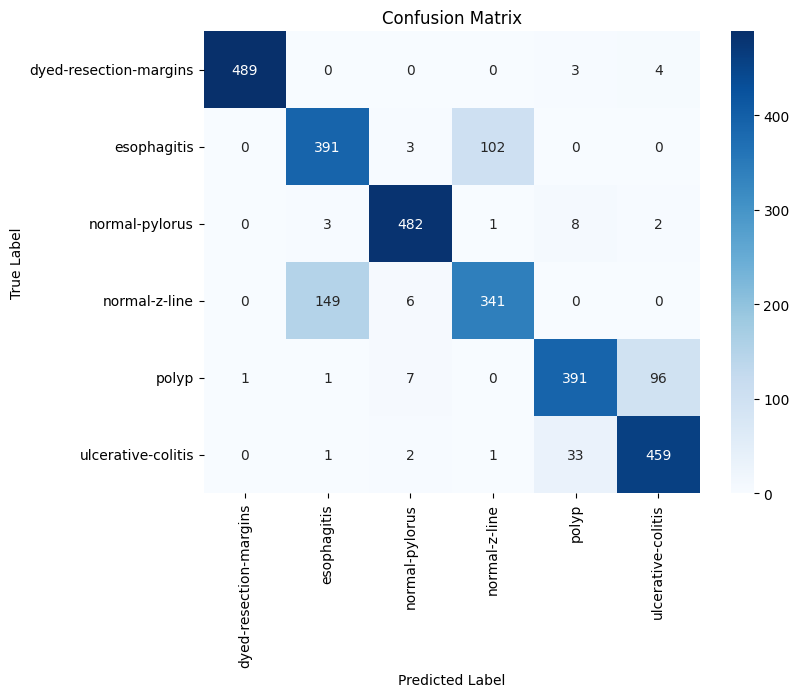

In [23]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Predict on test set
pred_probs = model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)  # Convert softmax probs to class indices
y_true = test_generator.classes          # True class indices

# Step 2: Class label names
class_labels = list(test_generator.class_indices.keys()) 

# Step 3: Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Step 4: Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


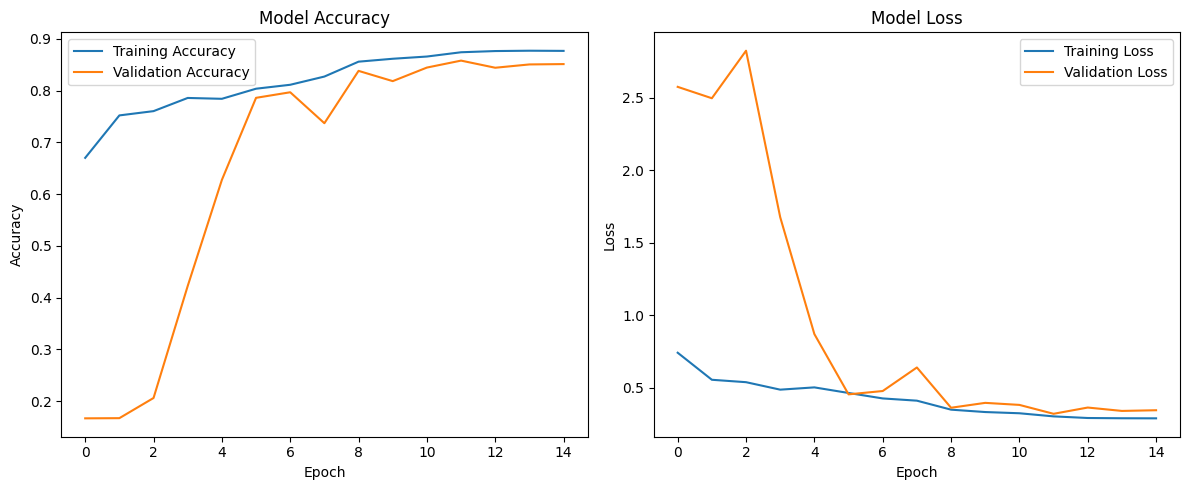

In [24]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [34]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Step 1: Load and preprocess image
img_path = '/kaggle/input/test-pictures/0d7ff5ea-15d9-4a8e-a2e8-77ee6b228738.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)

# Step 2: Predict
predictions = model.predict(img_array)
predicted_index = np.argmax(predictions, axis=1)[0]

# Step 3: Class labels
class_labels = list(train_generator.class_indices.keys())
predicted_class = class_labels[predicted_index]

# Step 4: Class-specific descriptions
class_descriptions = {
    "dyed-resection-margins": "Cancer recurrence risk: **10–15%**. Requires histological assessment.",
    "esophagitis": "Inflammation of the esophagus. Cancer risk is typically low unless chronic.",
    "normal-pylorus": "Normal tissue near stomach exit (pylorus). No immediate concern.",
    "normal-z-line": "Normal Z-line at gastroesophageal junction. No pathology detected.",
    "polyps": "Polyps have a cancer risk of **5–10%**, depending on type and dysplasia.",
    "ulcerative-colitis": "Chronic inflammation. Long-term UC may increase cancer risk significantly (>15%)."
}

# Step 5: Output Results
print(f"\nPredicted Class: {predicted_class}")
print(f"Description: {class_descriptions[predicted_class]}\n")

print("📊 Confidence Scores:")
for i, score in enumerate(predictions[0]):
    print(f"{class_labels[i]:<25}: {score:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Predicted Class: ulcerative-colitis
Description: Chronic inflammation. Long-term UC may increase cancer risk significantly (>15%).

📊 Confidence Scores:
dyed-resection-margins   : 0.0040
esophagitis              : 0.0000
normal-pylorus           : 0.0004
normal-z-line            : 0.0000
polyp                    : 0.1546
ulcerative-colitis       : 0.8410


In [30]:
from tensorflow.keras.models import load_model

model.save('densenet_model.h5')